# Imports

In [5]:
import sys
sys.path.insert(0, "../")


import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from src.dataloader import *
from src.metrics import *
from src.models import *
from triage.triage import Triage
from src.utils import *

uci_datasets = [
    "boston",
    "protein",
    "bike",
    "star",
    "blog_data",
    "concrete",
    "bio",
]

# 'boston', 'concrete', 'protein', 'bike', 'star', 'concrete', 'bio', 'los', "mimic_antibiotics", "cancer"
dataset = "boston"

n_runs = 10
seed = 100
seed_everything(seed=seed)

_ALL_REGRESSION_DATASETS = ALL_REGRESSION_DATASETS

# Get dataset

In [6]:
def data_helper(dataset):
    non_uci = False
    if dataset in ["mimic_antibiotics", "los", "prostate", "cancer", "prostate2"]:
        non_uci = True
    processing_needed = False

    impute = False
    if dataset in ["mimic_antibiotics", "los"]:
        impute = True

    if non_uci:
        data = load_medical(dataset)
        if len(data) == 4:
            df, outcome_variable, processing_needed, seed = data
        else:
            df_static, df_temporal, outcome_variable, processing_needed, seed = data

    if processing_needed and non_uci:
        ids_static = df_static.id.unique()
        ids_temporal = df_temporal[df_temporal["time"] == 0].id.unique()

        if len(ids_temporal) < len(ids_static):
            ids = ids_temporal
        else:
            ids = ids_static

        df_static = df_static[df_static.id.isin(ids)]
        df_temporal = df_temporal[df_temporal.id.isin(ids)]
        df_temporal = df_temporal[df_temporal["time"] == 0]

        df_temporal_label = df_temporal[df_temporal["variable"]
                                        == outcome_variable]
        if len(df_temporal_label) == 0:
            df_temporal_label = df_static[[outcome_variable, "id"]]

        if len(df_temporal_label) != len(df_temporal):
            ids = df_temporal_label.id
            df_static = df_static[df_static.id.isin(ids)]
            df_temporal = df_temporal[df_temporal.id.isin(ids)]

        df_static.shape, df_temporal[df_temporal["variable"]
                                     == outcome_variable].shape

        df_temporal = df_temporal.sort_values(by=["id"])
        df_static = df_static.sort_values(by=["id"])

        temporal_unique_ids = df_temporal.id.unique().shape
        static_shape = df_static.shape
        assert temporal_unique_ids[0] == static_shape[0]

        feature_dict = {}
        for variable_name in list(df_temporal.variable.unique()):
            tdf = df_temporal[df_temporal["variable"] == variable_name]
            variable_array = tdf.drop_duplicates(
                subset=["id"]).value.to_numpy()
            feature_dict[variable_name] = variable_array

        tmp_df = pd.DataFrame.from_dict(
            feature_dict, columns=df_static.id, orient="index"
        ).T.reset_index(level=0)

        tmp_df.shape
        df_overall = df_static.merge(tmp_df, on="id", how="left")

        assert df_overall[outcome_variable].shape[0] == static_shape[0]

    elif non_uci == False:
        pass

    else:
        df_overall = df

    if dataset in uci_datasets:
        regression_datasets = list(_ALL_REGRESSION_DATASETS.keys())
        regression_datasets.sort()

        if dataset in regression_datasets:
            # xlrd, openpyxl
            import tempfile

            dataset_name = regression_datasets[mapper[dataset]]
            with tempfile.TemporaryDirectory() as data_dir:
                # download and load data
                download_regression_dataset(dataset_name, data_dir)
                X, y = load_regression_dataset(
                    dataset_name, data_dir, shuffle_train=True, batch_size=512
                )
                print(dataset)
        else:
            X, y = GetDataset(dataset, "./data/")

    if dataset in uci_datasets:
        df_overall = pd.DataFrame(X)
        df_overall["y"] = y

        if len(df_overall) > 10000:
            df_overall = df_overall.sample(n=10000, random_state=seed)

            X = df_overall.drop(columns=["y"])
            y = df_overall["y"].values

    else:
        if len(df_overall) > 10000:
            df_overall = df_overall.sample(n=10000, random_state=seed)

        X = df_overall.drop(columns=[outcome_variable])
        y = df_overall[outcome_variable].values

        if dataset == "prostate2":
            X = X[prostate_feats]

    y = np.array([(y[i] - y.min()) / (y.max() - y.min())
                 for i in range(len(y))])

    if impute:
        from hyperimpute.plugins.imputers import Imputers

        Imputers()
        method = "mean"
        plugin = Imputers().get(method)
        X = plugin.fit_transform(X.copy())

    from sklearn import preprocessing

    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)

    return X, y

# Process dataset & Run TRIAGE as we slowly acquire features

In [7]:
nest = 20
seed = 0

try:

    X, y = data_helper(dataset=dataset)

    # compute correlations of feat-label for later ordering
    corrs = []
    for i in range(X.shape[1]):
        try:
            corr_val = np.corrcoef(X[:, i], y)[0, 1]
        except:
            corr_val = np.corrcoef(X[:, i], y.reshape(-1))[0, 1]
            y = y.reshape(-1)

        corr_val = np.abs(corr_val)

        corrs.append(corr_val)

    column_ids = np.argsort(corrs)

    ###########################################
    # DATA SPLITS
    ###########################################

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=seed
    )

    X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(
        X_train, y_train, test_size=0.2, random_state=seed
    )

    triage_list = []
    # RUN Triage as we slowly acquire more and more features
    for n in range(1, len(column_ids) + 1):

        learner = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
        learner.fit(X_prop_train[:, column_ids[0:n]], y_prop_train)

        X_eval_cols = X_prop_train[:, column_ids[0:n]]
        X_cal_cols = X_cal[:, column_ids[0:n]]
        X_eval = X_prop_train
        y_eval = y_prop_train

        triage = Triage(
            X_eval=X_eval_cols,
            y_eval=y_eval,
            X_cal=X_cal_cols,
            y_cal=y_cal,
            nest=nest,
            learner=learner,
        )
        groups_ids, raw_metrics = triage.run()

        # add this rounds triage score
        triage_list.append(raw_metrics["score_metric"])

    easy_uncert = []
    ambig_uncert = []
    hard_uncert = []

    oe_avg = []
    ue_avg = []
    we_avg = []

    n_oe = []
    n_we = []
    n_ue = []

    oe_samples = []
    ue_samples = []
    we_samples = []

    ###########################################
    # COMPUTE TRIAGE GROUPS
    ###########################################

    for i in range(len(triage_list)):
        d_idx = i

        triage_array = np.array(triage_list)[i, :, :]

        percentile_thresh = 75
        thresh = 0.25
        conf_thresh_low = thresh
        conf_thresh_high = 1 - thresh
        conf_thresh = 0.5

        variability = np.std(triage_array, axis=-1)
        confidence = np.mean(triage_array, axis=-1)

        uncert_percentile = np.percentile(variability, percentile_thresh)

        oe_ids = np.where(
            (confidence <= conf_thresh_low)
            & (variability <= np.percentile(variability, percentile_thresh))
        )[0]
        ue_ids = np.where(
            (confidence >= conf_thresh_high)
            & (variability <= np.percentile(variability, percentile_thresh))
        )[0]

        other_ids = np.concatenate((oe_ids, ue_ids))
        we_ids = []
        for id in range(len(confidence)):
            if id not in other_ids:
                we_ids.append(id)

        we_ids = np.array(we_ids)

        total = len(we_ids) + len(oe_ids) + len(ue_ids)

        # Number of samples per group
        n_oe.append(len(oe_ids) / total)
        n_ue.append(len(ue_ids) / total)
        n_we.append(len(we_ids) / total)

        # Get the samples per group
        oe_samples.append(oe_ids)
        ue_samples.append(ue_ids)
        we_samples.append(we_ids)

        # get average of the uncertainty metric per group
        oe_avg.append(np.mean(triage_array[oe_ids]))
        ue_avg.append(np.mean(triage_array[ue_ids]))
        we_avg.append(np.mean(triage_array[we_ids]))


except Exception as e:
    print(e)

boston


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Plot acquisiton curve

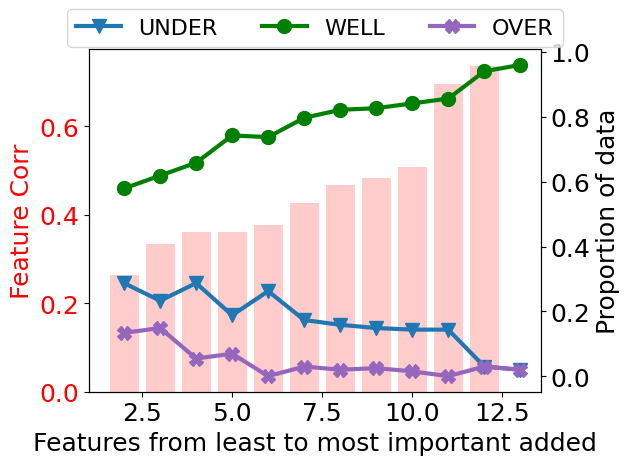

In [8]:
corr_vals = np.sort(corrs)


# Setup dummy data
N = len(corr_vals)
ind = np.arange(N)
bars = np.random.randn(N)
t = np.arange(0.01, 10.0, 0.01)

# Plot graph with 2 y axes
fig, ax1 = plt.subplots()

SIZE = 18
plt.rcParams["xtick.labelsize"] = SIZE
plt.rcParams["ytick.labelsize"] = SIZE
plt.rcParams["axes.labelsize"] = SIZE

# Plot bars
k = 1  # steps
start = 1
ax1.bar(ind[start + 1:: k], corr_vals[start + 1:: k], alpha=0.2, color="r")
ax1.set_xlabel("Features from least to most important added")

ax1.xaxis.label.set_size(SIZE)
ax1.yaxis.label.set_size(SIZE)
ax1.xaxis.set_tick_params(labelsize=SIZE)
ax1.yaxis.set_tick_params(labelsize=SIZE)


# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel("Feature Corr", color="r")
[tl.set_color("r") for tl in ax1.get_yticklabels()]


# Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()

scale = 1

xaxis = list(range(start + 1, len(ue_samples) + 1, k))
xaxis = [scale * x for x in xaxis]

ax2.plot(
    xaxis,
    n_ue[start::k],
    marker="v",
    label="UNDER",
    color="tab:blue",
    linewidth=3,
    markersize=10,
)
ax2.plot(
    xaxis,
    n_we[start::k],
    marker="o",
    label="WELL",
    color="g",
    linewidth=3,
    markersize=10,
)
ax2.plot(
    xaxis,
    n_oe[start::k],
    marker="X",
    label="OVER",
    color="tab:purple",
    linewidth=3,
    markersize=10,
)

# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel("Proportion of data", color="k")
[tl.set_color("k") for tl in ax2.get_yticklabels()]

ax2.xaxis.label.set_size(SIZE)
ax2.yaxis.label.set_size(SIZE)
ax2.xaxis.set_tick_params(labelsize=SIZE)
ax2.yaxis.set_tick_params(labelsize=SIZE)

plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=3, fontsize=16)
plt.tight_layout()
plt.show()